<a href="https://colab.research.google.com/github/RihamBichara/NLP-Projects/blob/main/YT_Comments_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview:

Exploring various sentiment analysis models:

VADER (bag of words approach)
Roberta
Huggingface Pipeline


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use('ggplot')
!pip install transformers
!pip install svgling

!pip install plotly.express
import plotly.express as px

from svgling import draw_tree

!pip install nltk
import nltk
from nltk.chunk import ne_chunk
nltk.download('punkt')
nltk.download('words')
nltk.download('vader_lexicon')
!python -m nltk.downloader maxent_ne_chunker
!python3 -m nltk.downloader averaged_perceptron_tagger

!pip install torch
import torch

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# Initialize an empty DataFrame to store the concatenated data
df = pd.DataFrame([])

# Iterate over the range of file indices
for i in range(24):
    try:
        # Read the CSV file for the current day
        dataset_1 = pd.read_csv(f'/content/drive/MyDrive/Trial/day{i+1}.csv')

        # Concatenate the current DataFrame with the total DataFrame
        df = pd.concat([df, dataset_1])
    except Exception as e:
        print(f"Error reading file for day {i+1}: {e}")
        pass

df.dropna(axis=0, inplace=True)
df= df.applymap(str)

df.info()

Error reading file for day 9: [Errno 2] No such file or directory: '/content/drive/MyDrive/Trial/day9.csv'
Error reading file for day 11: [Errno 2] No such file or directory: '/content/drive/MyDrive/Trial/day11.csv'
Error reading file for day 13: [Errno 2] No such file or directory: '/content/drive/MyDrive/Trial/day13.csv'
Error reading file for day 14: [Errno 2] No such file or directory: '/content/drive/MyDrive/Trial/day14.csv'
<class 'pandas.core.frame.DataFrame'>
Index: 2117110 entries, 0 to 181358
Data columns (total 4 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   messages     object
 1   all_authors  object
 2   timestamps   object
 3   money        object
dtypes: object(4)
memory usage: 80.8+ MB


In [3]:
df.head()

,messages,all_authors,timestamps,money
0,being pretty means you're innocent?,Ashlin Hiscox,-8:15,0
1,yeah pretty evil and abusive,PeppermintPisces99,-8:14,0
2,He has no background of arrests and harming in...,IAM#FREE2BME,-8:06,0
3,Only person anyone should be supporting is Joh...,Nolan A Hannigan,-8:01,0
4,When's it going to start? it's stopped countin...,mina coltart,-7:48,0


In [4]:
df['messages'].values[89]

'THERES THE RAT '

In [5]:
count = []
for i in range(24):
    try:
        dataset = pd.read_csv(f'/content/drive/MyDrive/Trial/day{i+1}.csv')
        count.append(np.mean(dataset['messages'].astype(str).str.split().map(lambda x:len(x))))
    except:
        count.append(0)
count_df = pd.DataFrame(count,columns=['Word count per comment'])
px.bar(count_df,title='Word length distribution across the trail',labels={'value':'# Words/ Comment','index':'Day number'})

In [6]:

count = []
for i in range(24):
    try:
        dataset = pd.read_csv(f'/content/drive/MyDrive/Trial/day{i+1}.csv')
        count.append(len(np.unique(dataset['all_authors'].astype(str))))
    except:
        count.append(0)
count_df = pd.DataFrame(count,columns=['Comment Count'])
px.bar(count_df,title='Number of unique accounts leaving comments',labels={'value':'# Comments','index':'Day number'})

In [7]:
print(df.shape)

df = df.head(100)
print(df.shape)

(2117110, 4)
(100, 4)


# EDA

In [8]:
# Generate IDs for each row
df['Id'] = range(1, len(df) + 1)

<ipython-input-8-25cb3aae38c4>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [9]:
df.head()

,messages,all_authors,timestamps,money,Id
0,being pretty means you're innocent?,Ashlin Hiscox,-8:15,0,1
1,yeah pretty evil and abusive,PeppermintPisces99,-8:14,0,2
2,He has no background of arrests and harming in...,IAM#FREE2BME,-8:06,0,3
3,Only person anyone should be supporting is Joh...,Nolan A Hannigan,-8:01,0,4
4,When's it going to start? it's stopped countin...,mina coltart,-7:48,0,5


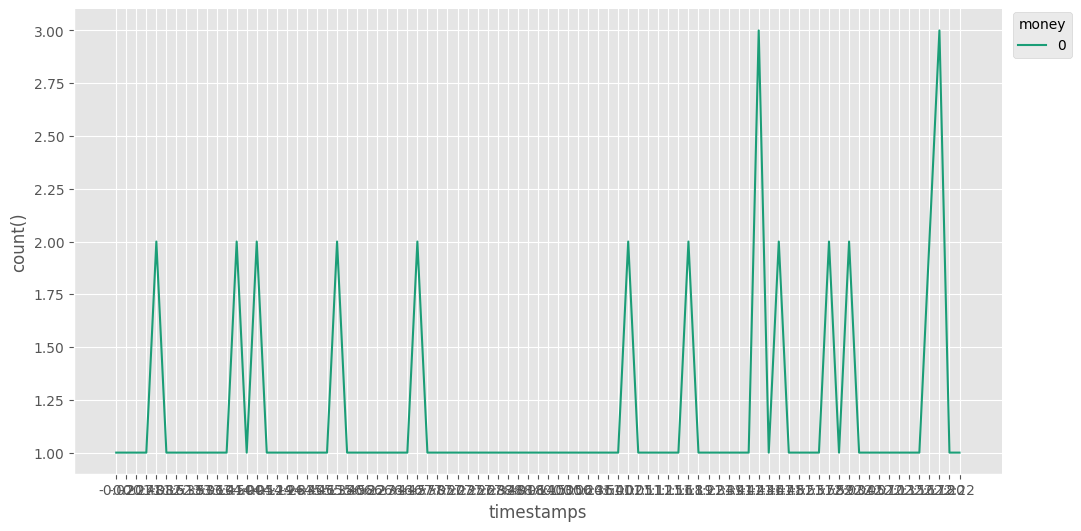

In [10]:
#  timestamps vs count()

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['timestamps']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'timestamps'}, axis=1)
              .sort_values('timestamps', ascending=True))
  xs = counted['timestamps']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('timestamps', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('money')):
  _plot_series(series, series_name, i)
  fig.legend(title='money', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamps')
_ = plt.ylabel('count()')

# NLTK

In [11]:
example = df['messages'][43]
print(example)

All these Hollywood people make me sick why dont they get a real job so then they can see how real people live they think they are better than every 1 else nothing special about them at all!!!!!!!!!!!


In [12]:
tokens=nltk.word_tokenize(example)
tokens

['All',
 'these',
 'Hollywood',
 'people',
 'make',
 'me',
 'sick',
 'why',
 'dont',
 'they',
 'get',
 'a',
 'real',
 'job',
 'so',
 'then',
 'they',
 'can',
 'see',
 'how',
 'real',
 'people',
 'live',
 'they',
 'think',
 'they',
 'are',
 'better',
 'than',
 'every',
 '1',
 'else',
 'nothing',
 'special',
 'about',
 'them',
 'at',
 'all',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!']

In [13]:
tagged= nltk.pos_tag(tokens)
tagged

[('All', 'PDT'),
 ('these', 'DT'),
 ('Hollywood', 'NNP'),
 ('people', 'NNS'),
 ('make', 'VBP'),
 ('me', 'PRP'),
 ('sick', 'JJ'),
 ('why', 'WRB'),
 ('dont', 'NN'),
 ('they', 'PRP'),
 ('get', 'VBP'),
 ('a', 'DT'),
 ('real', 'JJ'),
 ('job', 'NN'),
 ('so', 'RB'),
 ('then', 'RB'),
 ('they', 'PRP'),
 ('can', 'MD'),
 ('see', 'VB'),
 ('how', 'WRB'),
 ('real', 'JJ'),
 ('people', 'NNS'),
 ('live', 'VBP'),
 ('they', 'PRP'),
 ('think', 'VBP'),
 ('they', 'PRP'),
 ('are', 'VBP'),
 ('better', 'JJR'),
 ('than', 'IN'),
 ('every', 'DT'),
 ('1', 'CD'),
 ('else', 'RB'),
 ('nothing', 'NN'),
 ('special', 'JJ'),
 ('about', 'IN'),
 ('them', 'PRP'),
 ('at', 'IN'),
 ('all', 'DT'),
 ('!', '.'),
 ('!', '.'),
 ('!', '.'),
 ('!', '.'),
 ('!', '.'),
 ('!', '.'),
 ('!', '.'),
 ('!', '.'),
 ('!', '.'),
 ('!', '.'),
 ('!', '.')]

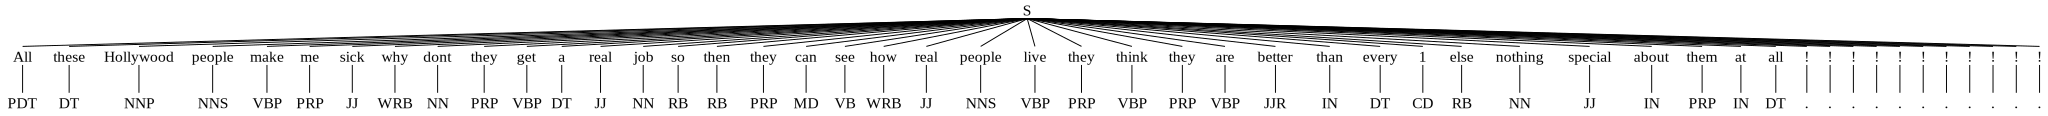

In [14]:
nltk.chunk.ne_chunk(tagged)

# VADER Seniment Scoring:
We'll utilize NLTK's SentimentIntensityAnalyzer for neg/pos analysis. Employing a bag of words approach involves:

Eliminating stop words
Scoring each word and aggregating them into a total score.






In [15]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [16]:
sia.polarity_scores('I am so happy')

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

In [17]:
sia.polarity_scores('This is the worst food ever')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [18]:
sia.polarity_scores(example)

{'neg': 0.158, 'neu': 0.774, 'pos': 0.068, 'compound': -0.5894}

In [19]:
#run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['messages']
    myid = row['Id']
    res[myid]= sia.polarity_scores(text)

  0%|          | 0/100 [00:00<?, ?it/s]

In [20]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index':'Id'})
vaders = vaders.merge(df, how='left')

In [21]:
# now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,messages,all_authors,timestamps,money
0,1,0.000,0.349,0.651,0.6808,being pretty means you're innocent?,Ashlin Hiscox,-8:15,0
1,2,0.573,0.067,0.360,-0.6369,yeah pretty evil and abusive,PeppermintPisces99,-8:14,0
2,3,0.442,0.558,0.000,-0.8271,He has no background of arrests and harming in...,IAM#FREE2BME,-8:06,0
3,4,0.000,0.734,0.266,0.4404,Only person anyone should be supporting is Joh...,Nolan A Hannigan,-8:01,0
4,5,0.192,0.808,0.000,-0.2263,When's it going to start? it's stopped countin...,mina coltart,-7:48,0


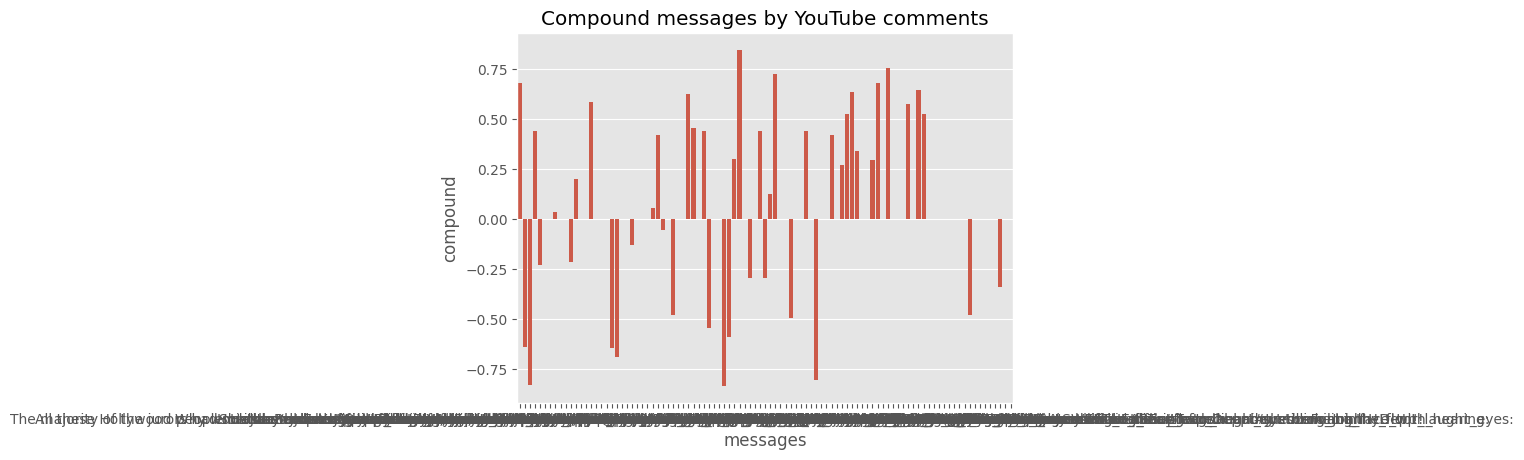

In [22]:
ax = sns.barplot(data=vaders, x='messages', y='compound')
ax.set_title('Compound messages by YouTube comments')
plt.show()

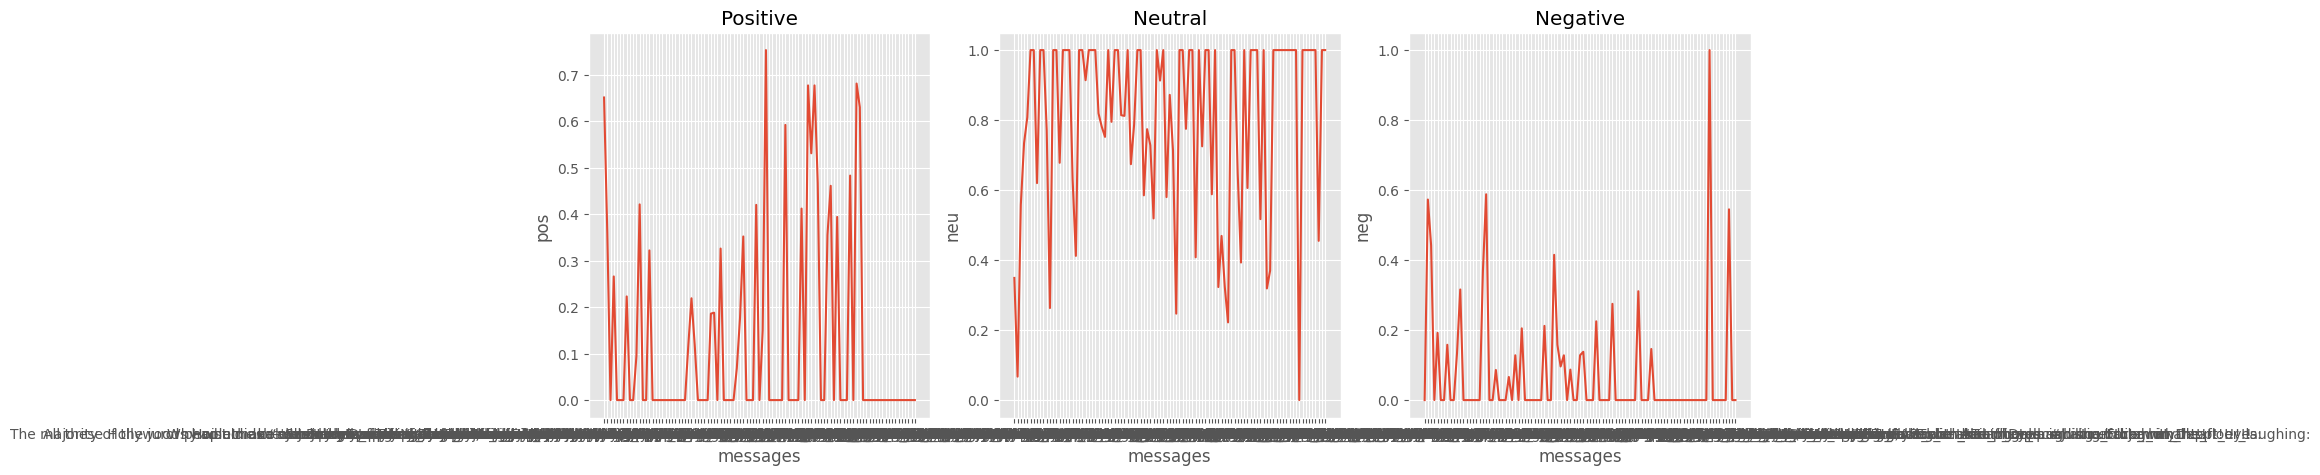

In [23]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

# Line plot for positive sentiment
sns.lineplot(data=vaders, x='messages', y='pos', ax=axs[0])
axs[0].set_title('Positive')

# Line plot for neutral sentiment
sns.lineplot(data=vaders, x='messages', y='neu', ax=axs[1])
axs[1].set_title('Neutral')

# Line plot for negative sentiment
sns.lineplot(data=vaders, x='messages', y='neg', ax=axs[2])
axs[2].set_title('Negative')

plt.show()

# Roberta Pretrained Model
use a model trained of a large corpus of data
transformer model ccount for the words but also the context related to other words

In [24]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from scipy.special import softmax

In [30]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [28]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
model_name = 'roberta-large'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(MODEL)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


OSError: Can't load tokenizer for 'cardiffnlp/twitter-roberta-base-sentiment'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure 'cardiffnlp/twitter-roberta-base-sentiment' is the correct path to a directory containing all relevant files for a RobertaTokenizerFast tokenizer.

In [31]:
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

In [32]:
#vader results
print(example)
sia.polarity_scores(example)

All these Hollywood people make me sick why dont they get a real job so then they can see how real people live they think they are better than every 1 else nothing special about them at all!!!!!!!!!!!


{'neg': 0.158, 'neu': 0.774, 'pos': 0.068, 'compound': -0.5894}

In [33]:
#Run for Roberta model
encoded_text=tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2],
}
print(scores_dict)

{'roberta_neg': 0.9413292, 'roberta_neu': 0.053285293, 'roberta_pos': 0.005385489}


In [34]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = softmax(output[0][0].detach().numpy())
    print(text)
    print(output)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [35]:
#run the roberta score on the entire dataset

res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['messages']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
          vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result, **roberta_result}
        res[myid] = both
    except runtimeError:
      print(f"Broke for id {myid}")


  0%|          | 0/100 [00:00<?, ?it/s]

being pretty means you're innocent?
SequenceClassifierOutput(loss=None, logits=tensor([[-0.1989,  0.6488, -0.2673]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
yeah pretty evil and abusive
SequenceClassifierOutput(loss=None, logits=tensor([[ 3.1071, -0.4353, -2.6885]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
He has no background of arrests and harming in relationships regarding DV, she does.
SequenceClassifierOutput(loss=None, logits=tensor([[ 1.1691,  1.0690, -2.3203]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
Only person anyone should be supporting is Johnny depp
SequenceClassifierOutput(loss=None, logits=tensor([[-0.0102,  0.6008, -0.6996]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
When's it going to start? it's stopped counting down.
SequenceClassifierOutput(loss=None, logits=tensor([[ 0.2731,  0.9503, -1.2903]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
are they doing t

In [36]:
result_df = pd.DataFrame(res).T
result_df = result_df.reset_index().rename(columns={'index':'Id'})
result_df = result_df.merge(df, how='left')

In [37]:
result_df.head()

,Id,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos,messages,all_authors,timestamps,money
0,1,0.000,0.349,0.651,0.6808,0.234291,0.546907,0.218802,being pretty means you're innocent?,Ashlin Hiscox,-8:15,0
1,2,0.573,0.067,0.360,-0.6369,0.969007,0.028046,0.002947,yeah pretty evil and abusive,PeppermintPisces99,-8:14,0
2,3,0.442,0.558,0.000,-0.8271,0.516719,0.467511,0.015770,He has no background of arrests and harming in...,IAM#FREE2BME,-8:06,0
3,4,0.000,0.734,0.266,0.4404,0.299039,0.550876,0.150085,Only person anyone should be supporting is Joh...,Nolan A Hannigan,-8:01,0
4,5,0.192,0.808,0.000,-0.2263,0.314681,0.619417,0.065903,When's it going to start? it's stopped countin...,mina coltart,-7:48,0


# Combine and compare
combine and comparing past models

In [38]:
result_df.columns

Index(['Id', 'neg', 'neu', 'pos', 'compound', 'roberta_neg', 'roberta_neu',
       'roberta_pos', 'messages', 'all_authors', 'timestamps', 'money'],
      dtype='object')

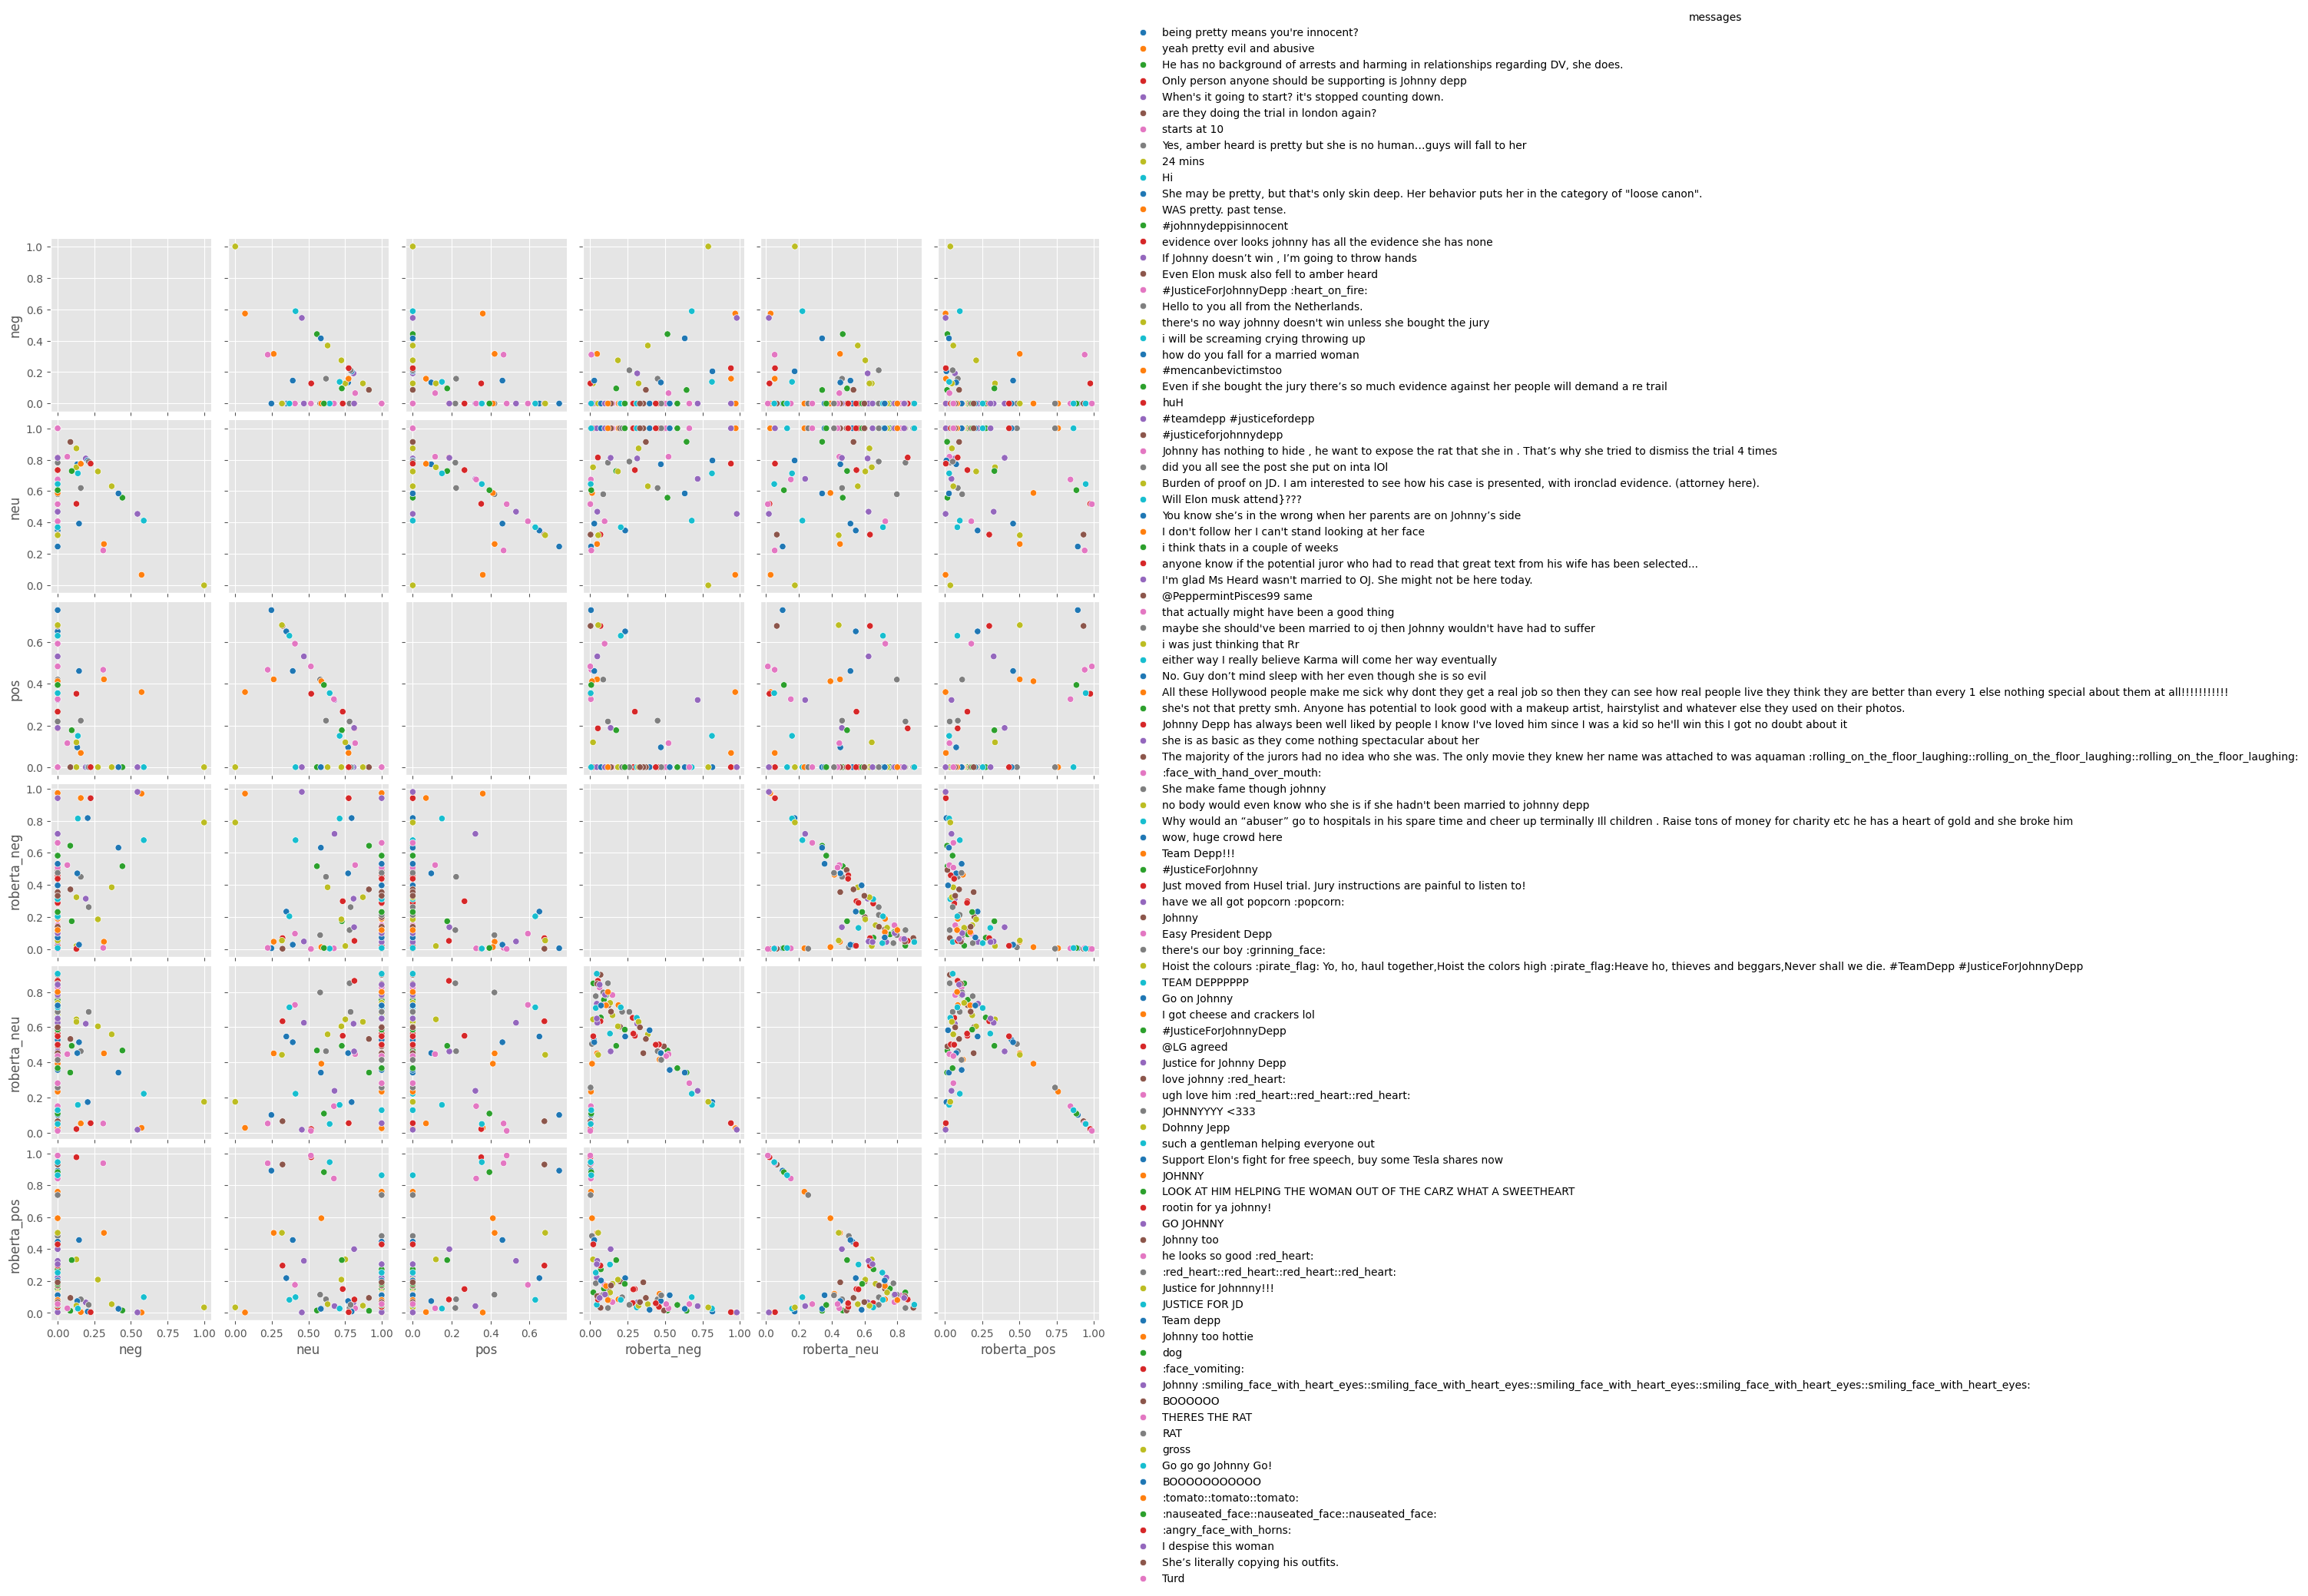

In [39]:
sns.pairplot(data=result_df, vars=['neg','neu', 'pos',
                                  'roberta_neg','roberta_neu', 'roberta_pos' ],
                                   hue='messages',
                                   palette='tab10')
plt.show()

# Hugging face


In [40]:
from transformers import pipeline
sent_pipeline = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english', revision='af0f99b')

In [44]:
sent_pipeline(' i hate this phone so bad')

[{'label': 'NEGATIVE', 'score': 0.9996557235717773}]

In [43]:
sent_pipeline(' I really want her to win this case')

[{'label': 'POSITIVE', 'score': 0.9982403516769409}]

In [48]:
example

'All these Hollywood people make me sick why dont they get a real job so then they can see how real people live they think they are better than every 1 else nothing special about them at all!!!!!!!!!!!'

In [49]:
sent_pipeline(example)

[{'label': 'NEGATIVE', 'score': 0.9966734647750854}]